In [189]:
import sys
sys.path.append('../../')

from functools import partial
from aml_project import utils
from aml_project.models import BaseModule
from aml_project import trainer
import biosppy.signals.ecg as ecg
import seaborn as sns
import matplotlib.pyplot as plt
import copy

import scipy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import pandas as pd
import skorch
from skorch import NeuralNetClassifier
from skorch.callbacks import EpochScoring, Initializer, LRScheduler, TensorBoard
from sklearn.metrics import classification_report, confusion_matrix, f1_score, make_scorer
import sklearn
from sklearn.base import TransformerMixin
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

from sklearn.multiclass import OneVsRestClassifier
import pywt
import cv2

In [2]:
#X_train, X_test, y_train = utils.load_df('data', 0)

In [220]:
%%time
X = pd.read_csv('data/X_train_normalized.csv')

CPU times: user 11.9 s, sys: 779 ms, total: 12.7 s
Wall time: 13.9 s


In [221]:
%%time
X_test = pd.read_csv('data/X_test_normalized.csv')

CPU times: user 11.4 s, sys: 285 ms, total: 11.7 s
Wall time: 11.8 s


In [222]:
%%time
y = pd.read_csv('data/y_train.csv')

CPU times: user 1.75 ms, sys: 1.37 ms, total: 3.12 ms
Wall time: 3.73 ms


In [223]:
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y.y)

In [7]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape, type(y_train), type(y_val)

((3837, 8652),
 (1280, 8652),
 (3837, 2),
 (1280, 2),
 pandas.core.frame.DataFrame,
 pandas.core.frame.DataFrame)

In [224]:
def load_data(source_x, source_y=None, sampling_rate=150, wavelet='mexh', thresh=0.2, dims=(100, 100), train=True, n_samples=0):
    before, after = 90, 110
    groups= []
    if type(source_x) == str:
        df_x = pd.read_csv(source_x)
    else:
        df_x = source_x

    if n_samples > 0:
            df_x = df_x.iloc[:n_samples]
        
    scales = pywt.central_frequency(wavelet) * sampling_rate / np.arange(1, dims[0] + 1, 1)
    
    if train:
        if type(source_y) == str:
            arr_y = pd.read_csv(source_y).y.values
        else:
            arr_y = source_y.y.values

    x_cwt_train, x_rr_train, y_train = [], [], []
    for j in range(len(df_x)):
        signal = df_x.iloc[j].dropna()    
        coefs, freq = pywt.cwt(signal, scales, wavelet, 1.0 / sampling_rate)
        rpeaks = ecg.engzee_segmenter(signal, sampling_rate, threshold=thresh)['rpeaks']
        
        avg_rri = np.mean(np.diff(rpeaks))
        
        x_cwt, x_rr, y = [], [], []
        for i in range(len(rpeaks)):
            if i == 0 or i == len(rpeaks) - 1:
                continue
                
            
            
            x_cwt.append(
                cv2.resize(coefs[:, max(rpeaks[i] - before, 0):min(rpeaks[i] + after, coefs.shape[1])], dims)
            )
            x_rr.append([
                rpeaks[i] - rpeaks[i - 1] - avg_rri,  # previous RR Interval
                rpeaks[i + 1] - rpeaks[i] - avg_rri,  # post RR Interval
                (rpeaks[i] - rpeaks[i - 1]) / (rpeaks[i + 1] - rpeaks[i]),  # ratio RR Interval
                np.mean(np.diff(rpeaks[np.maximum(i - 10, 0):i + 1])) - avg_rri  # local RR Interval
            ])
            
            if train:
                y.append(arr_y[j])
                
            groups.append(j)
        
        x_cwt_train.append(x_cwt)
        x_rr_train.append(x_rr)
        
        if train:
            y_train.append(y)
    
    x_cwt_train = np.expand_dims(np.concatenate(x_cwt_train, axis=0), axis=1).astype(np.float32)
    x_rr_train = np.concatenate(x_rr_train, axis=0).astype(np.float32)
    x_rr_train = RobustScaler().fit_transform(x_rr_train)
    
    if train:
        y_train = np.concatenate(y_train, axis=0).astype(np.int64)
        return x_cwt_train, x_rr_train, y_train, np.array(groups).astype(np.int64)
    
    return x_cwt_train, x_rr_train, np.array(groups).astype(np.int64)

In [69]:
%%time
#x_cwt_train, x_rr_train, y_train, groups = load_data('data/X_train_clean.csv', 'data/y_train.csv', n_samples=100)

CPU times: user 16.8 s, sys: 622 ms, total: 17.4 s
Wall time: 17.6 s


array([ 116,  159,  262,  324,  401,  561,  713,  863,  945, 1014, 1170,
       1321])

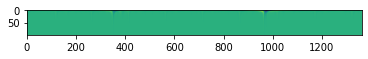

In [129]:
j=2282
signal = X_train.iloc[j]
signal = X_train.iloc[j].dropna()
sampling_rate = 150
dims=(100, 100)
thresh=0.2
wavelet = 'mexh'
scales = pywt.central_frequency(wavelet) * sampling_rate / np.arange(1, dims[0] + 1, 1)
rpeaks = ecg.engzee_segmenter(signal, sampling_rate, threshold=thresh)['rpeaks']

cwt_signal, _ = pywt.cwt(signal, scales, wavelet, 1.0 / sampling_rate)
plt.imshow(cwt_signal)
rpeaks

In [225]:
%%time
x_cwt_train, x_rr_train, y_train, groups_train = load_data(X_train, y_train, n_samples=0, dims=(50, 50))

CPU times: user 3min 34s, sys: 6.3 s, total: 3min 41s
Wall time: 3min 45s


In [226]:
%%time
x_cwt_val, x_rr_val, y_val, groups_val = load_data(X_val, y_val, n_samples=0, dims=(50, 50))

CPU times: user 1min 11s, sys: 1.14 s, total: 1min 12s
Wall time: 1min 13s


In [227]:
%%time
x_cwt_test, x_rr_test, groups_test = load_data(X_test, train=False, n_samples=0, dims=(50, 50))

CPU times: user 4min 45s, sys: 9.06 s, total: 4min 54s
Wall time: 5min 3s


In [35]:
len(x_cwt_test.shape), len(X_train.shape)

(4, 2)

In [228]:
def plot_signal(data, idx, titles=[]):
    
    if type(idx) == int:
        idx = range(idx)
        
    width = 20
    ncols = 1
    if len(data.shape) > 2:
        ncols = 5
        width = 2
        
    nrows = len(idx) // ncols
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*width, nrows*5))
    if len(idx) > 1:
        axes = axes.flatten()
    else:
        axes = [axes]
    for i, ax in enumerate(axes):
        if len(data.shape) > 2:
            ax.imshow(data[i][0])
        else:
            measurements = data.iloc[i].dropna().to_numpy(dtype='float32')
            #measurements = measurements[0:-1:10]
            measurements /= 1000
            seconds = np.arange(0, len(measurements)) / 30
            ax.plot(seconds, measurements)
        if len(titles) > 0:
            ax.set_title(titles[idx[i]])

In [84]:
len(titles)

1280

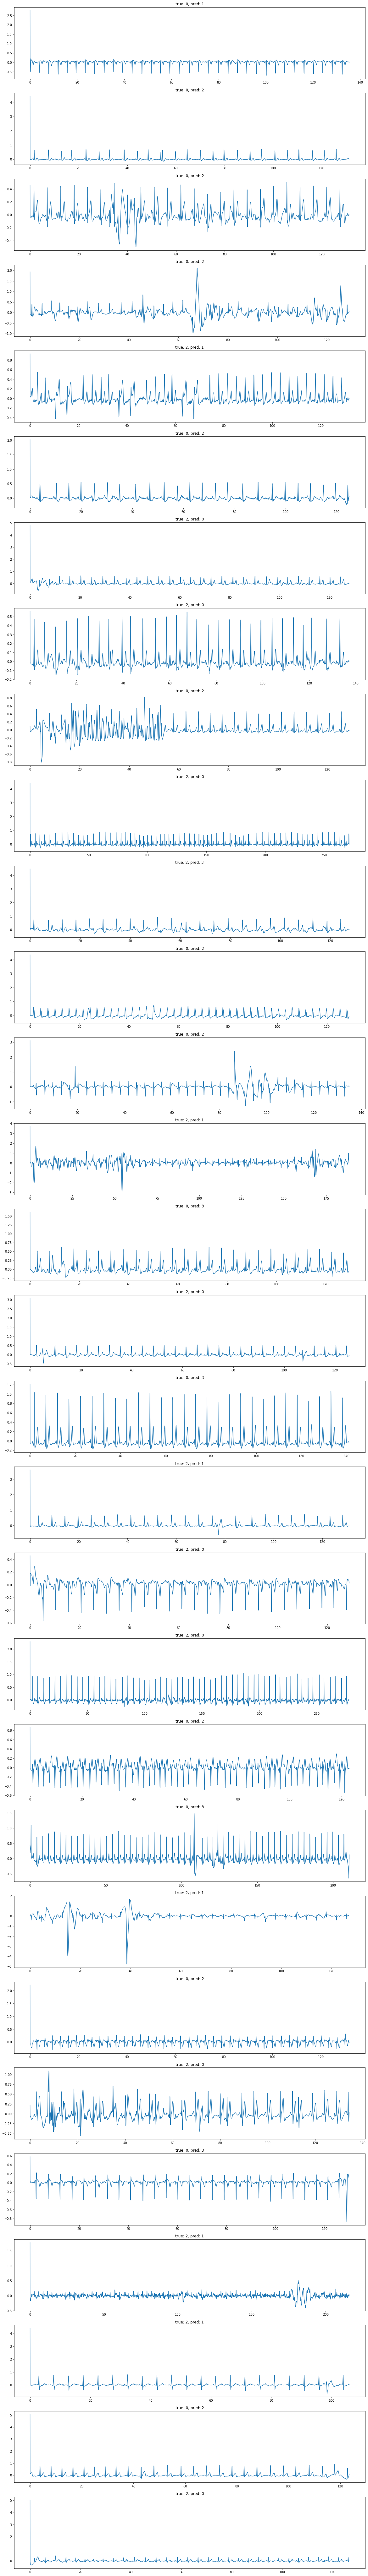

In [88]:
plot_signal(X_train, miss_clf[:30], titles=titles)

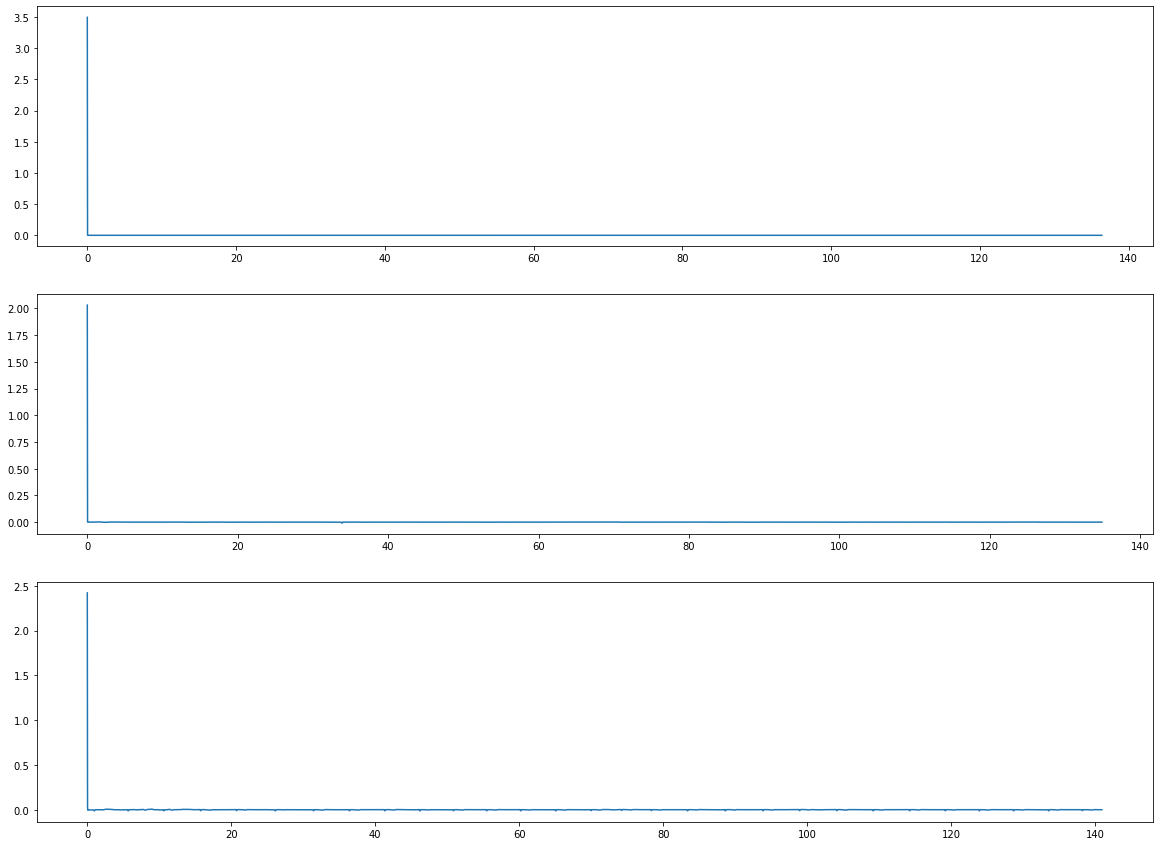

In [229]:
plot_signal(X_train, [1, 2, 3])

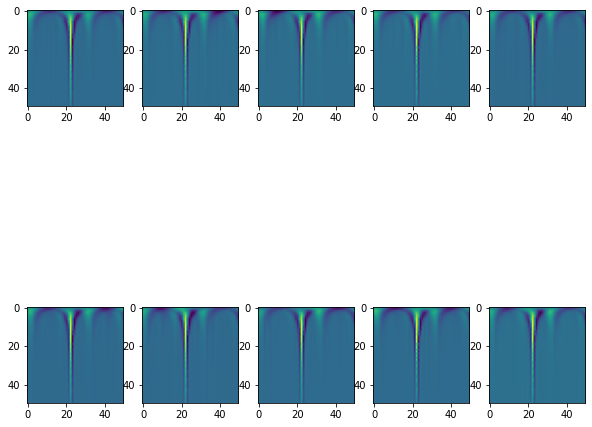

In [230]:
plot_signal(x_cwt_train, 10)

In [231]:
class MyModule(nn.Module):
    def __init__(self, n_classes=4):
        super(MyModule, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 7)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.conv3 = nn.Conv2d(32, 64, 2)#self.conv3 = nn.Conv2d(32, 64, 3)
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        self.pooling1 = nn.MaxPool2d(5)
        self.pooling2 = nn.MaxPool2d(3)
        self.pooling3 = nn.AdaptiveMaxPool2d((1, 1))
        self.fc1 = nn.Linear(68, 32)
        self.fc2 = nn.Linear(32, n_classes)

    def forward(self, x1, x2):
        x1 = F.relu(self.bn1(self.conv1(x1)))  # (16 x 94 x 94)
        x1 = self.pooling1(x1)  # (16 x 18 x 18)
        x1 = F.relu(self.bn2(self.conv2(x1)))  # (32 x 16 x 16)
        x1 = self.pooling2(x1)  # (32 x 5 x 5)
        x1 = F.relu(self.bn3(self.conv3(x1)))  # (64 x 3 x 3)
        x1 = self.pooling3(x1)  # (64 x 1 x 1)
        x1 = x1.view((-1, 64))  # (64,)
        x = torch.cat((x1, x2), dim=1)  # (68,)
        x = F.relu(self.fc1(x))  # (32,)
        x = self.fc2(x)  # (4,)
        return x

In [19]:
class_weights =  5117 / torch.tensor([3030, 443, 1474, 170])
class_weights

tensor([ 1.6888, 11.5508,  3.4715, 30.1000])

In [ ]:
def label_one_vs_all(one_class):
    # return idx_one, idx_all
def pred_patients(X, groups, model):
    # return y_pred

In [237]:
callbacks = [
    Initializer("[conv|fc]*.weight", fn=torch.nn.init.kaiming_normal_),
    Initializer("[conv|fc]*.bias", fn=partial(torch.nn.init.constant_, val=0.0)),
    LRScheduler(policy=StepLR, step_size=5, gamma=0.1),
    EpochScoring(scoring=make_scorer(f1_score, average="macro"), lower_is_better=False, name="valid_f1"),
    #TensorBoard(SummaryWriter(log_dir))
]

In [262]:
class SpecificVsRestClassifier(TransformerMixin):
    def __init__(self, clf, one_class):
        self.clf = copy.deepcopy(clf)
        self.one_class = one_class
    
    def split_one_vs_rest(self, y):
        idx_one = np.where(y == self.one_class)[0]
        idx_rest = np.where(y != self.one_class)[0]
        return idx_one, idx_rest
    
    def fit(self, X, y):
        idx_one, idx_rest = self.split_one_vs_rest(y)
        y_one_vs_rest = np.zeros_like(y)
        y_one_vs_rest[idx_one] = 1
        
        # Balance class weights
        if type(self.clf) == skorch.classifier.NeuralNetClassifier:
            n_samples = len(y_one_vs_rest)
            print(n_samples, len(idx_rest), len(idx_one))
            class_weight = n_samples / torch.tensor([len(idx_rest), len(idx_one)])
            self.clf.estimator__weight = class_weight
            print(f'set class weight to: {class_weight}')
        else:
            self.clf.class_weigth = 'balanced'
        self.clf.fit(X, y_one_vs_rest)
        return self
    
    def transform(self, X, y=None):
        return self.clf.predict(X)

In [263]:
# Noise vs rest
noise_vs_rest_net = NeuralNetClassifier(  # skorch is extensive package of pytorch for compatible with scikit-learn
    MyModule(n_classes=2),
    criterion=torch.nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam,
    lr=0.01,
    max_epochs=10,
    batch_size=1024,
    #train_split=predefined_split(Dataset({"x1": x1_test, "x2": x2_test}, y_test)),
    verbose=1,
    #device="cuda",
    callbacks=callbacks,
    #iterator_train__shuffle=True,
    optimizer__weight_decay=0,
)

In [264]:
s=-1
noise_vs_rest_clf = SpecificVsRestClassifier(noise_vs_rest_net, 3)
noise_vs_rest_clf.fit({'x1': x_cwt_train[:s], 'x2': x_rr_train[:s]}, y_train[:s])

130615 126353 4262
set class weight to: tensor([ 1.0337, 30.6464])
  epoch    train_loss    valid_acc    valid_f1    valid_loss      lr      dur
-------  ------------  -----------  ----------  ------------  ------  -------
      1        0.1415       0.9673      0.4917        0.0956  0.0100  60.9427
      2        0.1063       0.9675      0.4964        0.0866  0.0100  60.4031
      3        0.1005       0.9677      0.5079        0.0844  0.0100  59.9905
      4        0.0974       0.9686      0.5473        0.0827  0.0100  59.5585
      5        0.0959       0.9690      0.5556        0.0822  0.0100  60.3617
      6        0.0887       0.9686      0.5473        0.0802  0.0010  60.1534
      7        0.0867       0.9691      0.5614        0.0790  0.0010  60.2981
      8        0.0857       0.9693      0.5727        0.0784  0.0010  59.5141
      9        0.0849       0.9698      0.5860        0.0780  0.0010  58.9270
     10        0.0843       0.9704      0.6007        0.0775  0.0010  59.04

In [265]:
# Healthy vs sick
healthy_vs_sick_net = NeuralNetClassifier(  # skorch is extensive package of pytorch for compatible with scikit-learn
    MyModule(n_classes=2),
    criterion=torch.nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam,
    lr=0.01,
    max_epochs=10,
    batch_size=1024,
    #train_split=predefined_split(Dataset({"x1": x1_test, "x2": x2_test}, y_test)),
    verbose=1,
    #device="cuda",
    callbacks=callbacks,
    #iterator_train__shuffle=True,
    optimizer__weight_decay=0,
)

In [266]:
idx_noise, idx_rest = noise_vs_rest_clf.split_one_vs_rest(y_train)

x_cwt_train_rest = x_cwt_train[idx_rest]
x_rr_train_rest = x_rr_train[idx_rest]
y_train_rest = y_train[idx_rest]

healthy_vs_sick_clf = SpecificVsRestClassifier(healthy_vs_sick_net, 0)
healthy_vs_sick_clf.fit({'x1': x_cwt_train_rest, 'x2': x_rr_train_rest}, y_train_rest)

126354 54009 72345
set class weight to: tensor([2.3395, 1.7465])
  epoch    train_loss    valid_acc    valid_f1    valid_loss      lr      dur
-------  ------------  -----------  ----------  ------------  ------  -------
      1        0.6094       0.7272      0.7242        0.5730  0.0100  58.8712
      2        0.5541       0.7265      0.7246        0.5534  0.0100  57.7074
      3        0.5370       0.7352      0.7339        0.5580  0.0100  57.8471
      4        0.5236       0.7625      0.7584        0.5136  0.0100  58.0802
      5        0.5197       0.7544      0.7517        0.5220  0.0100  57.4877
      6        0.4958       0.7731      0.7545        0.4892  0.0010  57.7764
      7        0.4841       0.7753      0.7575        0.4857  0.0010  57.6480
      8        0.4799       0.7755      0.7585        0.4833  0.0010  57.6628
      9        0.4769       0.7770      0.7609        0.4817  0.0010  57.0090
     10        0.4744       0.7779      0.7626        0.4803  0.0010  57.8871

In [267]:
# Sick vs sick
sick_vs_sick_net = NeuralNetClassifier(  # skorch is extensive package of pytorch for compatible with scikit-learn
    MyModule(n_classes=2),
    criterion=torch.nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam,
    lr=0.01,
    max_epochs=10,
    batch_size=1024,
    #train_split=predefined_split(Dataset({"x1": x1_test, "x2": x2_test}, y_test)),
    verbose=1,
    #device="cuda",
    callbacks=callbacks,
    #iterator_train__shuffle=True,
    optimizer__weight_decay=0,
)

In [268]:
idx_healthy, idx_sick = healthy_vs_sick_clf.split_one_vs_rest(y_train_rest)

x_cwt_train_sick = x_cwt_train[idx_sick]
x_rr_train_sick = x_rr_train[idx_sick]
y_train_sick = y_train[idx_sick]

sick_vs_sick_clf = SpecificVsRestClassifier(healthy_vs_sick_net, 1)
sick_vs_sick_clf.fit({'x1': x_cwt_train_sick, 'x2': x_rr_train_sick}, y_train_sick)

54009 48459 5550
set class weight to: tensor([1.1145, 9.7314])
  epoch    train_loss    valid_acc    valid_f1    valid_loss      lr      dur
-------  ------------  -----------  ----------  ------------  ------  -------
      1        0.4319       0.8965      0.4866        0.3094  0.0100  24.9962
      2        0.2852       0.8962      0.4753        0.2962  0.0100  24.8574
      3        0.2629       0.8969      0.4950        0.2747  0.0100  24.5335
      4        0.2488       0.8959      0.6003        0.2714  0.0100  25.0003
      5        0.2357       0.9038      0.6225        0.2568  0.0100  24.6059
      6        0.2151       0.9059      0.6501        0.2504  0.0010  24.4677
      7        0.2059       0.9049      0.6524        0.2485  0.0010  24.3970
      8        0.2019       0.9059      0.6606        0.2466  0.0010  24.4481
      9        0.1989       0.9068      0.6665        0.2453  0.0010  24.7166
     10        0.1959       0.9074      0.6752        0.2438  0.0010  24.4855


In [272]:
s = 10
y_pred = sick_vs_sick_clf.transform({'x1': x_cwt_val[:s], 'x2': x_rr_val[:s]})
y_pred = sick_vs_sick_clf.one_class

In [ ]:
def predict_patients(clfs, X):
    y_pred = []
    for clf in clfs:
        y_pred = clf.transform(X)
        y_pre
        idx_pred, idx_empty = clf.split_one_vs_rest(y_)
    

In [21]:
%%time
net.fit({'x1': x_cwt_train, 'x2': x_rr_train}, y_train)

  epoch    train_loss    valid_acc    valid_f1    valid_loss      lr      dur
-------  ------------  -----------  ----------  ------------  ------  -------
      1        1.3530       0.4871      0.4246        1.1630  0.0010  64.3184
      2        1.1418       0.5365      0.4531        1.1017  0.0010  62.3102
      3        1.0772       0.5598      0.4714        1.0623  0.0010  62.1270
      4        1.0374       0.5759      0.4904        1.0371  0.0010  61.7806
      5        1.0096       0.5925      0.5026        1.0212  0.0010  61.6510
      6        0.9664       0.5836      0.4906        1.0192  0.0001  62.0657
      7        0.9461       0.5833      0.4925        1.0138  0.0001  61.7416
      8        0.9405       0.5839      0.4933        1.0108  0.0001  62.2257
      9        0.9362       0.5842      0.4943        1.0081  0.0001  61.7397
     10        0.9323       0.5851      0.4955        1.0054  0.0001  62.0358
     11        0.9242       0.5848      0.4938        1.0081  0.

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=MyModule(
    (conv1): Conv2d(1, 16, kernel_size=(7, 7), stride=(1, 1))
    (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (conv3): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1))
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pooling1): MaxPool2d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
    (pooling2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (pooling3): AdaptiveMaxPool2d(output_size=(1, 1))
    (fc1): Linear(in_features=68, out_features=32, bias=True)
    (fc2): Linear(in_features=32, out_features=4, bias=True)
  ),
)

In [22]:

torch.cuda.is_available()

False

In [22]:
import pickle
with open('cwt_cnn_cleaned.pkl', 'wb') as f:
    pickle.dump(net, f)

In [43]:
x_cwt_test, x_rr_test, groups = load_data('data/X_test.csv', '', train=False)

In [44]:
x_cwt_test.shape, x_rr_test.shape, groups.shape

((123542, 1, 100, 100), (123542, 4), (123542,))

In [23]:
preds_beat = net.predict({'x1':x_cwt_val, 'x2': x_rr_val})

In [28]:
y_val.shape, y_preds.shape

((45504,), (1280,))

In [29]:
df_preds = pd.DataFrame({'groups': groups_val, 'preds': preds_beat, 'truth': y_val})
df_preds_grouped = df_preds.groupby('groups').agg(lambda x: x.value_counts().index[0])
y_preds = df_preds_grouped.preds.values
y_val_grouped = df_preds_grouped.truth.values

In [31]:
from sklearn.metrics import f1_score

f1_score(y_val_grouped, y_preds, average='weighted')

0.6766670613804765

In [65]:
miss_clf = np.where(y_preds != y_val_grouped)[0]
miss_clf

array([   1,    3,    5,    8,   18,   19,   21,   24,   29,   32,   34,
         37,   38,   39,   40,   45,   48,   59,   60,   61,   64,   65,
         68,   72,   74,   77,   78,   84,   88,   97,   99,  101,  106,
        108,  113,  115,  117,  120,  126,  135,  136,  144,  145,  146,
        149,  150,  155,  156,  157,  159,  161,  168,  171,  178,  179,
        182,  184,  186,  189,  198,  199,  201,  203,  204,  211,  212,
        216,  218,  220,  222,  223,  227,  229,  230,  232,  235,  237,
        238,  242,  247,  254,  257,  259,  264,  266,  270,  273,  276,
        278,  280,  284,  285,  286,  287,  289,  290,  291,  293,  294,
        297,  298,  299,  300,  304,  306,  308,  316,  318,  320,  321,
        325,  327,  330,  333,  337,  343,  348,  349,  351,  359,  365,
        367,  369,  372,  375,  380,  389,  393,  398,  400,  405,  406,
        407,  413,  417,  420,  426,  427,  429,  430,  431,  432,  433,
        435,  437,  443,  448,  452,  454,  455,  4

In [79]:
i=5
y_preds[i], y_val_grouped[i] 

(2, 0)

In [80]:
titles

['true: 0, pred: 0',
 'true: 0, pred: 1',
 'true: 1, pred: 1',
 'true: 0, pred: 2',
 'true: 0, pred: 0',
 'true: 0, pred: 2',
 'true: 0, pred: 0',
 'true: 0, pred: 0',
 'true: 0, pred: 2',
 'true: 0, pred: 0',
 'true: 0, pred: 0',
 'true: 1, pred: 1',
 'true: 0, pred: 0',
 'true: 0, pred: 0',
 'true: 0, pred: 0',
 'true: 0, pred: 0',
 'true: 0, pred: 0',
 'true: 0, pred: 0',
 'true: 2, pred: 1',
 'true: 0, pred: 2',
 'true: 0, pred: 0',
 'true: 2, pred: 0',
 'true: 0, pred: 0',
 'true: 0, pred: 0',
 'true: 2, pred: 0',
 'true: 2, pred: 2',
 'true: 1, pred: 1',
 'true: 0, pred: 0',
 'true: 2, pred: 2',
 'true: 0, pred: 2',
 'true: 2, pred: 2',
 'true: 0, pred: 0',
 'true: 2, pred: 0',
 'true: 1, pred: 1',
 'true: 2, pred: 3',
 'true: 0, pred: 0',
 'true: 0, pred: 0',
 'true: 0, pred: 2',
 'true: 0, pred: 2',
 'true: 2, pred: 1',
 'true: 0, pred: 3',
 'true: 0, pred: 0',
 'true: 0, pred: 0',
 'true: 1, pred: 1',
 'true: 2, pred: 2',
 'true: 2, pred: 0',
 'true: 2, pred: 2',
 'true: 0, pr

In [81]:
titles = [f'true: {t}, pred: {p}' for t, p in zip(y_val_grouped, y_preds)]

TypeError: 'zip' object is not subscriptable

In [148]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10)

In [139]:
heartbeats.shape
series = heartbeats.reshape(-1)

In [143]:
i = 0
signal = X_train.iloc[i]
sampling_rate = 150
rpeaks = ecg.engzee_segmenter(signal, sampling_rate)['rpeaks']
heartbeats = ecg.extract_heartbeats(signal, rpeaks, sampling_rate)['templates']
heartbeats.shape

(33, 90)

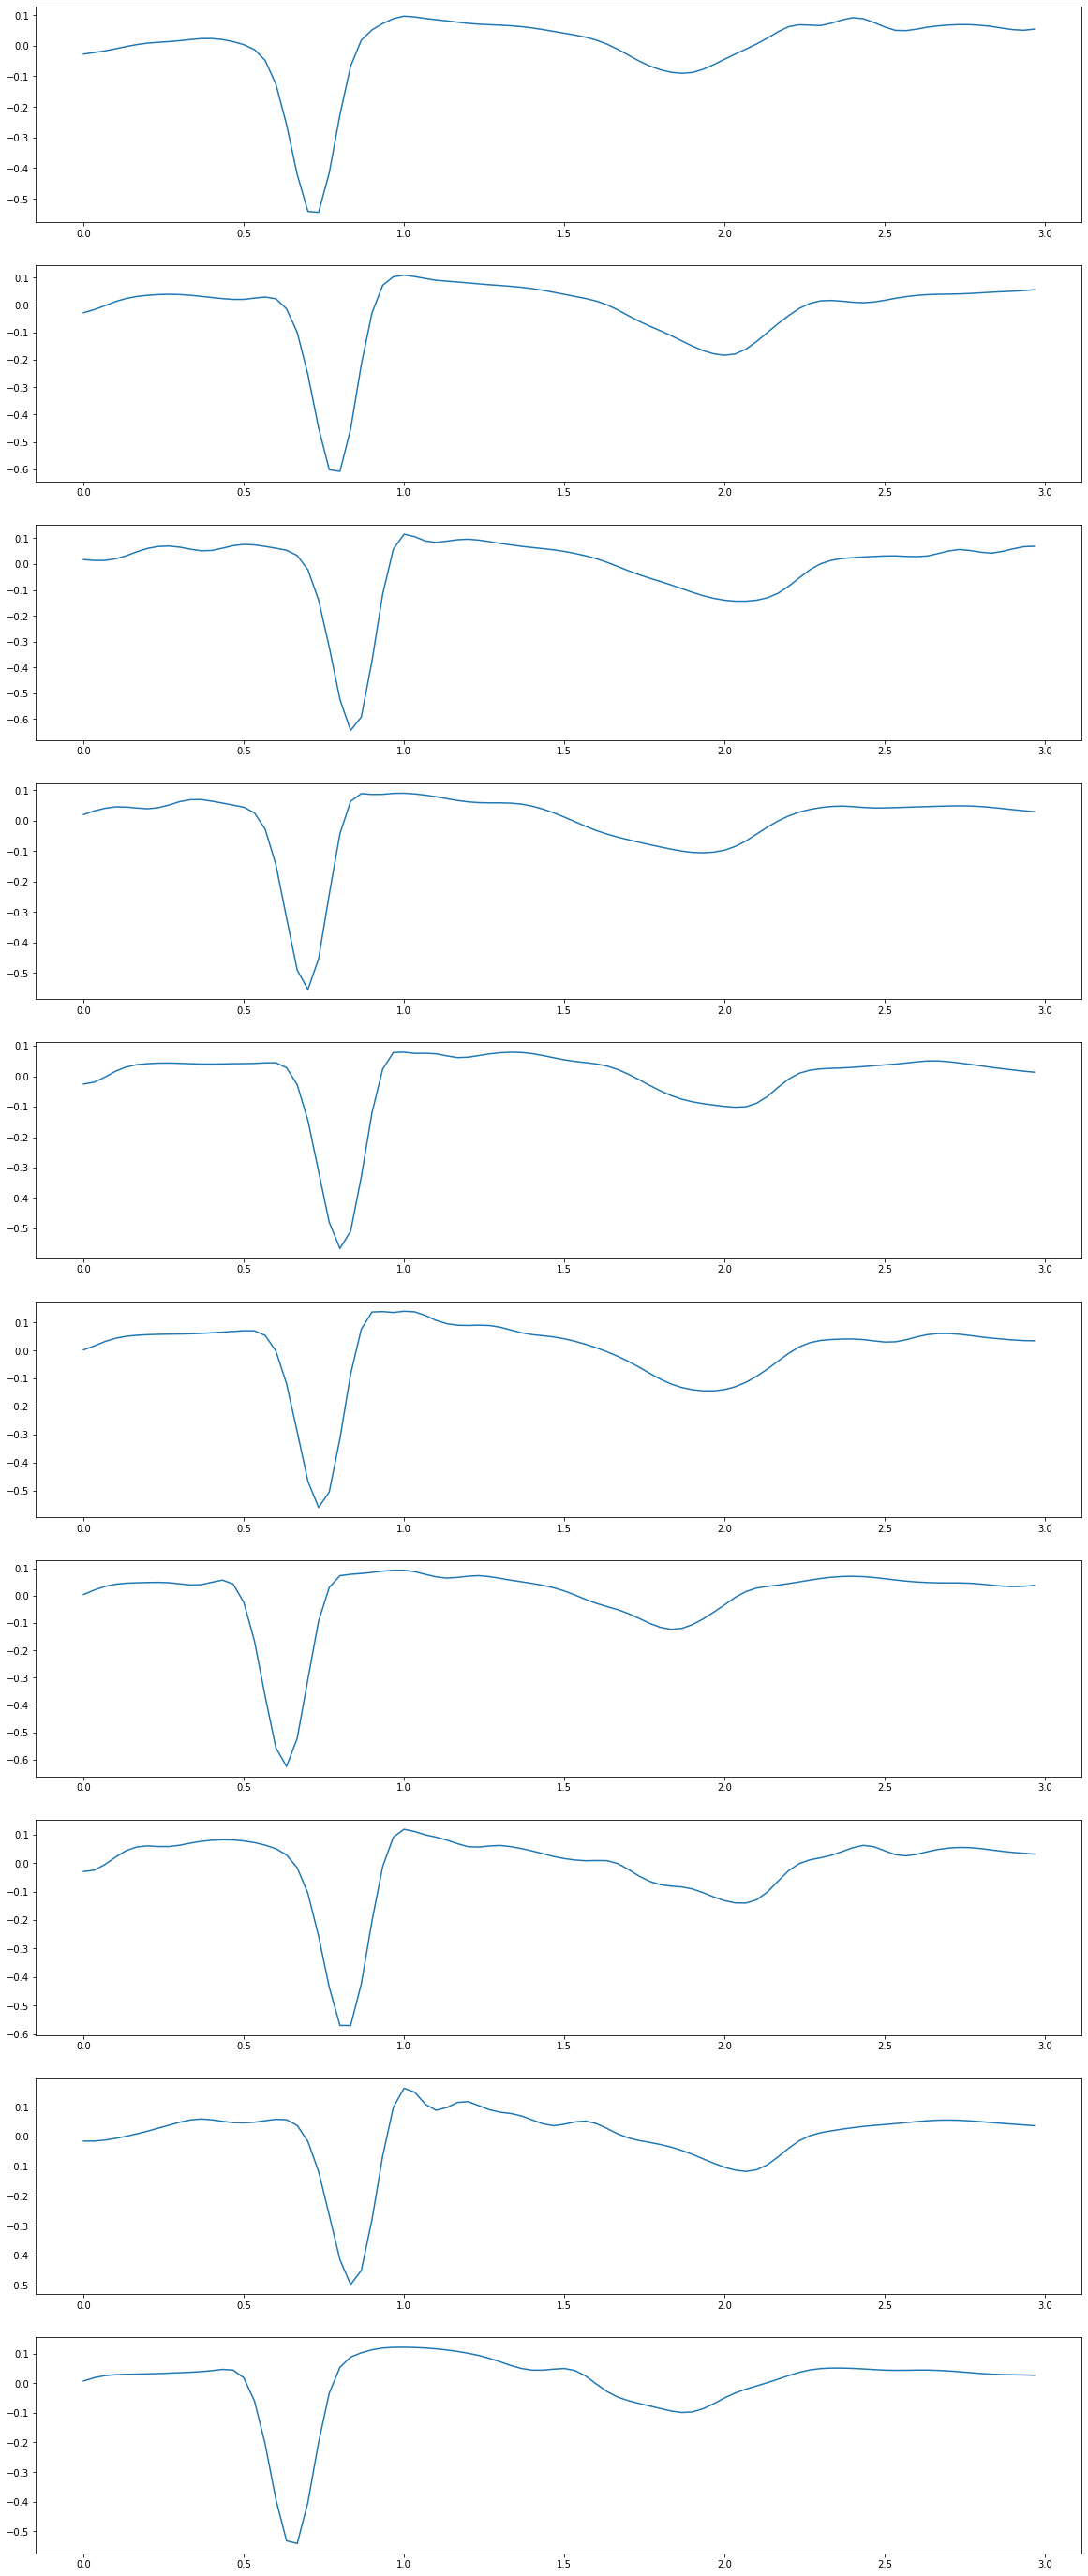

In [144]:
plot_signal(pd.DataFrame(heartbeats), 10)

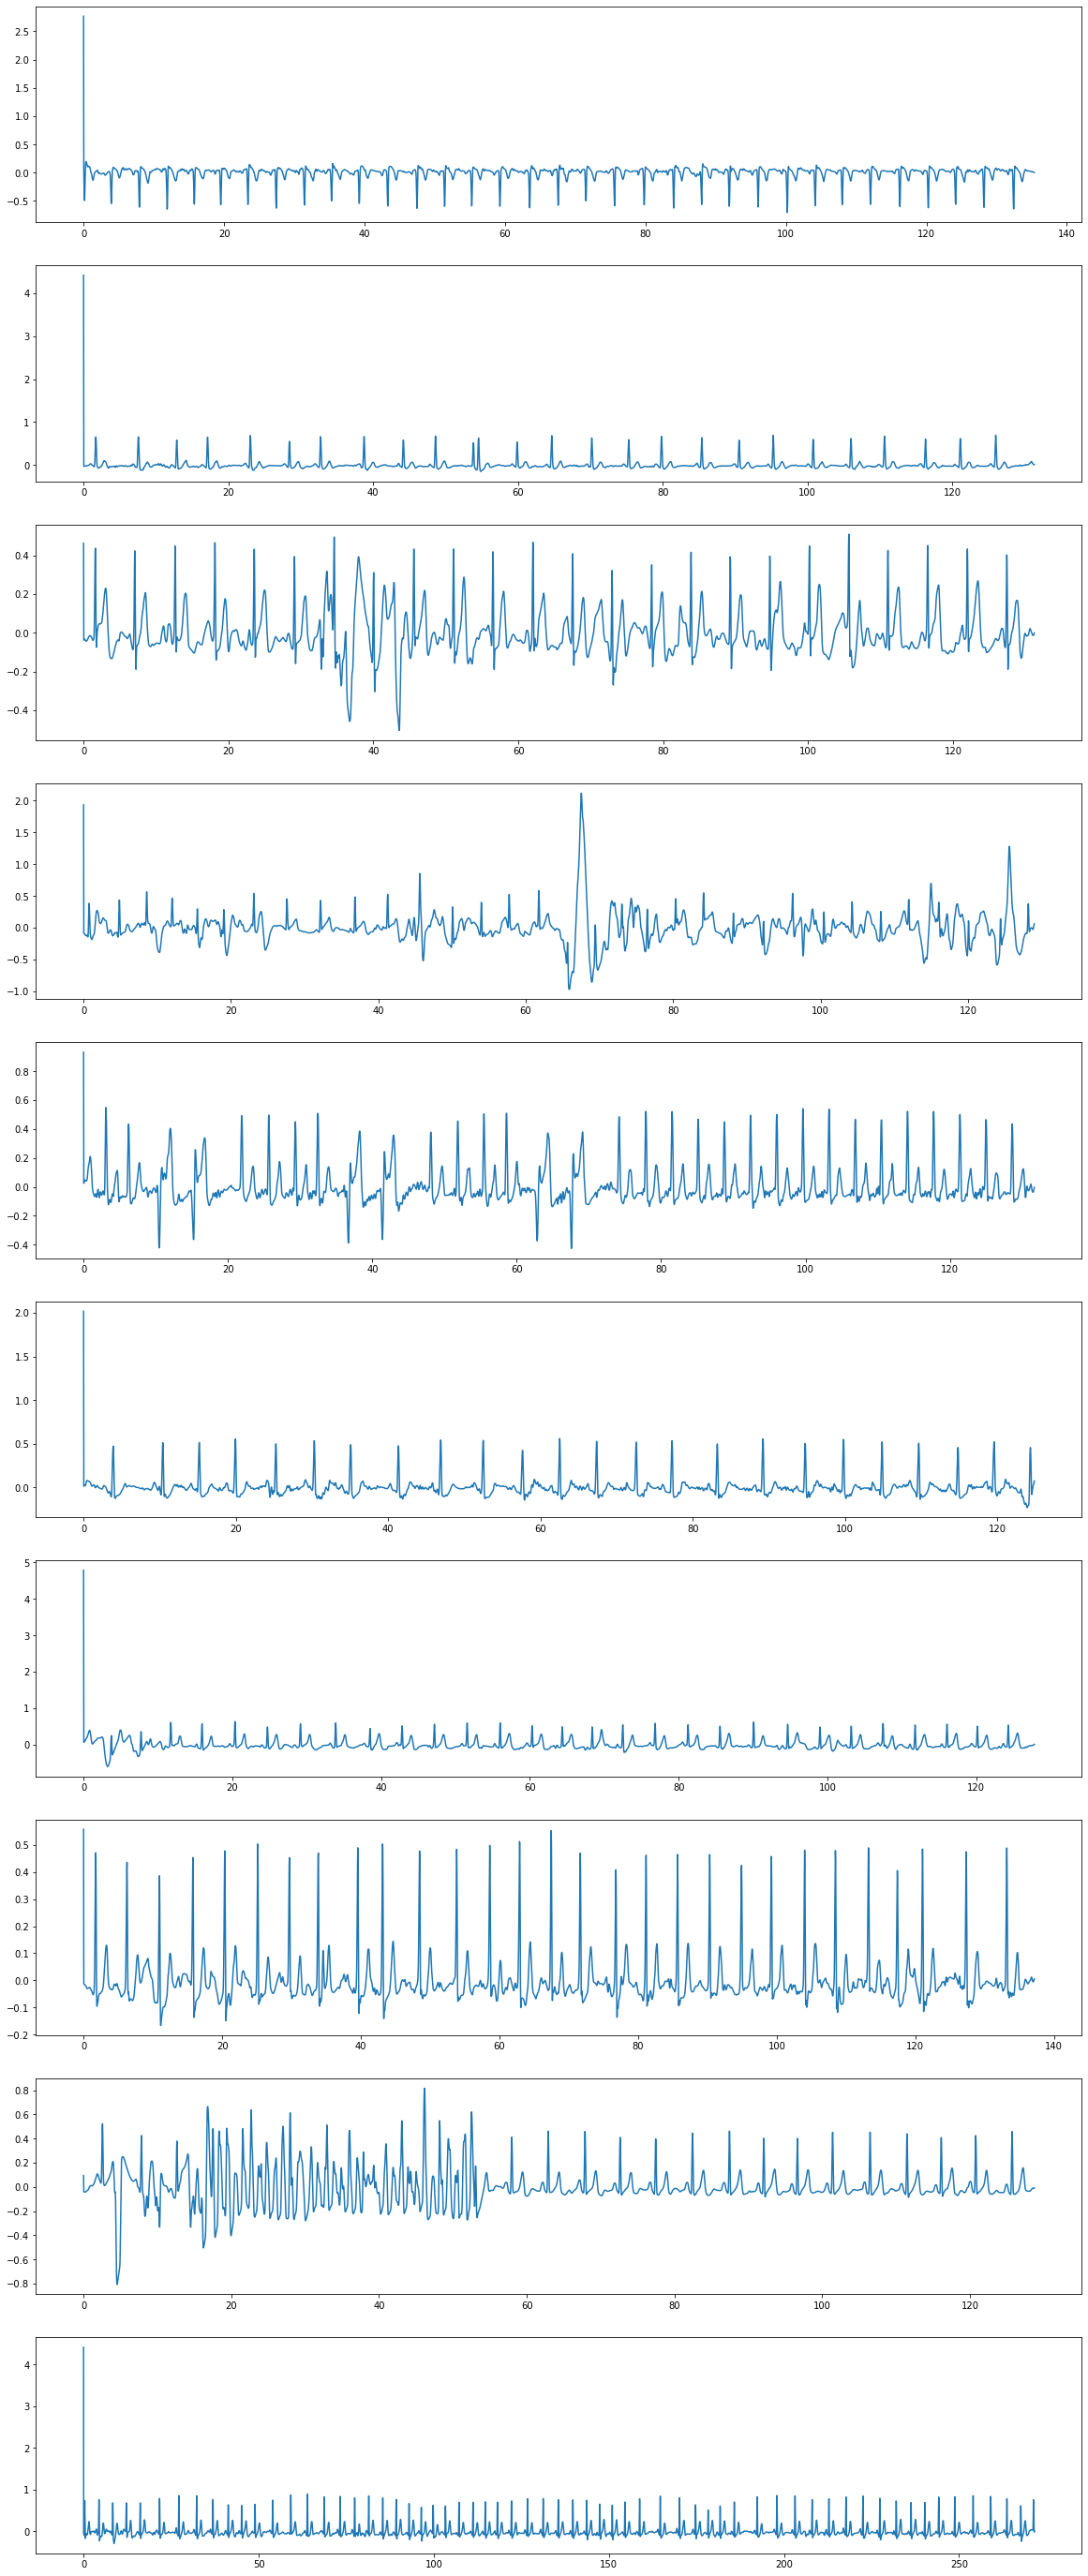

In [142]:
plot_signal(X_train, 10)

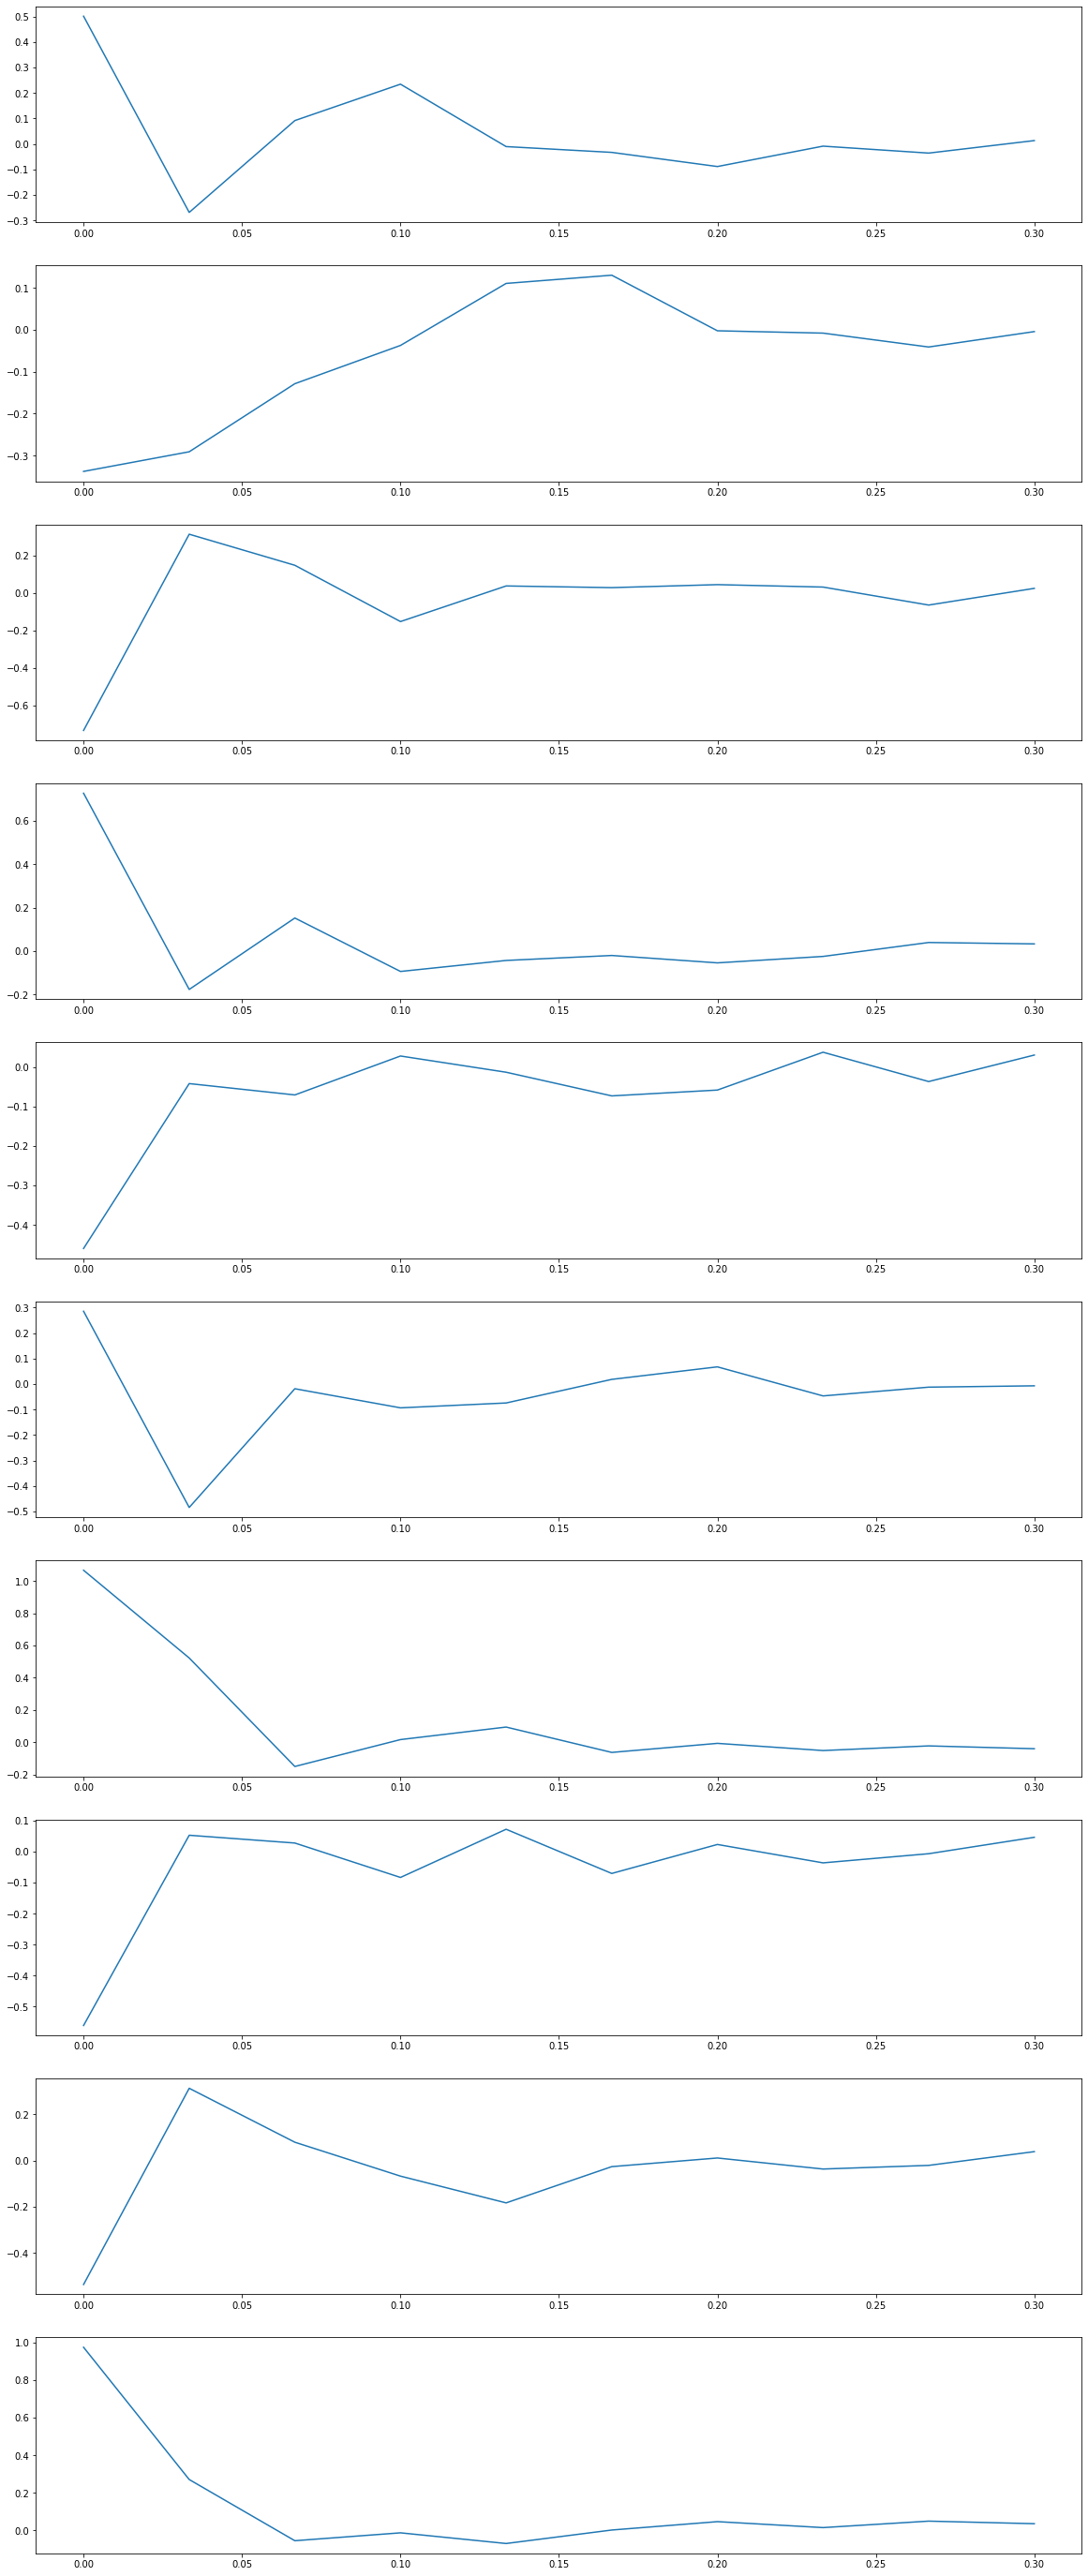

In [149]:
heartbeats_pca = pca.fit_transform(heartbeats)
plot_signal(pd.DataFrame(heartbeats_pca), 10)